## Takeaway name classifier deep learning live demo


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
import string
from unidecode import unidecode


## Build a Fastai Data Loader

Load in the dataframe and extract indexes for training, validation and balanced trainings.

In [152]:
df = pd.read_csv('30_05_2020_baseline_4000.csv')

valid_idx = df[df.valid].index
train_idx = df[~df.valid].index

bal_idx = []
for k, v in zip(df.index, df.bal):
    bal_idx += [k]*v



In [153]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [154]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'@&)(." +"0123456789")

In [155]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [156]:
train_df = df.iloc[train_idx, [3,2]]
bal_df = df.iloc[bal_idx, [3,2]]
valid_df = df.iloc[valid_idx, [3,2]]

## Classifier with Just Eat data

In [157]:
data = TextClasDataBunch.from_df(path='.', train_df=bal_df, valid_df=valid_df,
                         tokenizer=tokenizer, vocab=vocab,
                         mark_fields=False, bs=128)

In [158]:
learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.4, bptt=70)


In [159]:
learn.load('baseline_4000')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (36074 items)
x: TextList
xxbos   s o u t h e r n   f r i e d   c h i c k e n     a n d     p i z z a,xxbos   s o u t h e r n   f r i e d   c h i c k e n     a n d     p i z z a,xxbos   m a h a r a n i   i n d i a n   c u i s i n e,xxbos   s w e e t   j a m r o c k,xxbos   z a a f r a n
y: CategoryList
Fast Food,Fast Food,Indian,Fast Food,Indian
Path: .;

Valid: LabelList (3600 items)
x: TextList
xxbos   j     a n d     d   k e b a b,xxbos   p o p   i n,xxbos   f a m i l y   k e b a b     a n d     p i z z a r i a,xxbos   s h a k e xxunk   w a f f l e   n   r o l l,xxbos   b e a c h   h o u s e
y: CategoryList
Kebab,Fish & Chips,Fast Food,Desserts,Fish & Chips
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(46, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(46, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): 

In [160]:
learn.predict("cluckers")

(Category Fast Food,
 tensor(3),
 tensor([1.9759e-02, 1.1667e-03, 1.8922e-04, 4.9732e-01, 4.1393e-02, 1.3564e-01,
         9.4269e-04, 1.0385e-01, 1.9975e-01]))

In [ ]:
learn.predict("")

In [ ]:
learn.predict("")

In [ ]:
learn.predict("")

In [ ]:
learn.predict("")

In [ ]:
learn.predict("")

In [ ]:
learn.predict("")

In [ ]:
learn.predict("")

In [ ]:
learn.predict("")

In [ ]:
learn.predict("")

In [53]:
learn.predict("al-jafal cafe")


(Category Sand/Caf/Bake,
 tensor(8),
 tensor([0.0148, 0.0014, 0.0148, 0.0255, 0.0009, 0.0127, 0.0011, 0.0288, 0.9001]))

In [54]:
learn.predict("azka turkish")

(Category Kebab,
 tensor(6),
 tensor([6.9196e-05, 1.8460e-06, 3.3990e-07, 1.7144e-04, 5.2559e-06, 6.1387e-03,
         9.9256e-01, 1.0464e-03, 1.0089e-05]))

In [33]:
learn.predict("mama's jerk shack")

(Category Chicken,
 tensor(0),
 tensor([0.4425, 0.0036, 0.0296, 0.3497, 0.0018, 0.0174, 0.0767, 0.0638, 0.0150]))

In [34]:
learn.predict("rajbelash")

(Category Indian,
 tensor(5),
 tensor([1.9287e-07, 1.2178e-05, 6.5106e-08, 1.1999e-03, 8.0287e-05, 9.9857e-01,
         2.2180e-07, 1.0198e-04, 3.6710e-05]))

In [52]:
learn.predict("kuru kuru sushi")

(Category Indian,
 tensor(5),
 tensor([5.4736e-02, 5.8851e-02, 7.6315e-05, 1.7239e-03, 2.3571e-05, 8.7561e-01,
         1.1728e-03, 1.6975e-03, 6.1054e-03]))

In [51]:
learn.predict("a batter plaice")

(Category Fish & Chips,
 tensor(4),
 tensor([5.4348e-05, 1.8897e-04, 7.2036e-07, 5.2216e-04, 9.9902e-01, 2.8162e-05,
         9.9606e-06, 1.3103e-04, 4.2695e-05]))

In [50]:
learn.predict("momaliks")

(Category Indian,
 tensor(5),
 tensor([0.0125, 0.0060, 0.0347, 0.2803, 0.0089, 0.3051, 0.0350, 0.0882, 0.2291]))

In [29]:
    def confusion_matrix(self):
        "Confusion matrix as an `np.ndarray`"
        x=torch.arange(0,data.c)
        cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        return cm.cpu().numpy()

    def plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", figsize:tuple=None):
        "Plot the confusion matrix"
        # This function is copied from the scikit docs
        cm = self.confusion_matrix()
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, self.data.classes, rotation=45)
        plt.yticks(tick_marks, self.data.classes)

        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [40]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [161]:
#txt_ci = TextClassificationInterpretation.from_learner(learn)
interp2 = TextClassificationInterpretation(learn, *learn.get_preds(with_loss=True, ordered=True))

In [162]:
#txt_ci.show_top_losses(20)
blah = interp2.show_top_losses(10000)


Text,Prediction,Actual,Loss,Probability
xxbos s w e e t s ' n ' t r e a t s,Desserts,Sand/Caf/Bake,22.76,0.00
xxbos g r i l l a z,Chicken,Sand/Caf/Bake,18.13,0.00
xxbos k h a o g a e n g t h a i,Chinese,Chicken,17.87,0.00
xxbos t h e f l a v o u r,Chicken,Sand/Caf/Bake,17.53,0.00
xxbos j a n d j c a f e,Sand/Caf/Bake,Desserts,16.63,0.00
xxbos s u n s h i n e d e l i,Sand/Caf/Bake,Chicken,16.56,0.00
xxbos m a d i n a d e l i g h t s d u n d e e,Desserts,Chicken,15.97,0.00
xxbos f u s e,Chinese,Desserts,15.49,0.00
xxbos d i n e r z,Fast Food,Sand/Caf/Bake,15.12,0.00
xxbos h u n g r y v e g a n,Fast Food,Desserts,14.97,0.00


In [163]:
my_top_losses = interp2.top_losses()
my_ds = interp2.data.dl('Valid').dataset
my_classes = interp2.data.valid_ds.classes
my_preds_class = interp2.pred_class
tl_val,tl_idx = my_top_losses


items = []
for idx in tl_idx:
    tx,cl = interp2.data.valid_ds[idx]
    cl = cl.data
    txt =  ' '.join([''.join(i.split()) for i in re.split(r' {2,}',tx.text)])[6:]
    tmp = [txt, f'{my_classes[my_preds_class[idx]]}', f'{my_classes[cl]}']
    items.append(tmp)
items = np.array(items)
names = ['Text', 'Prediction', 'Actual']
df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)

In [52]:
#df.to_csv('13_01_2020_errors.csv', index=False)

In [164]:
cm = interp2.confusion_matrix()

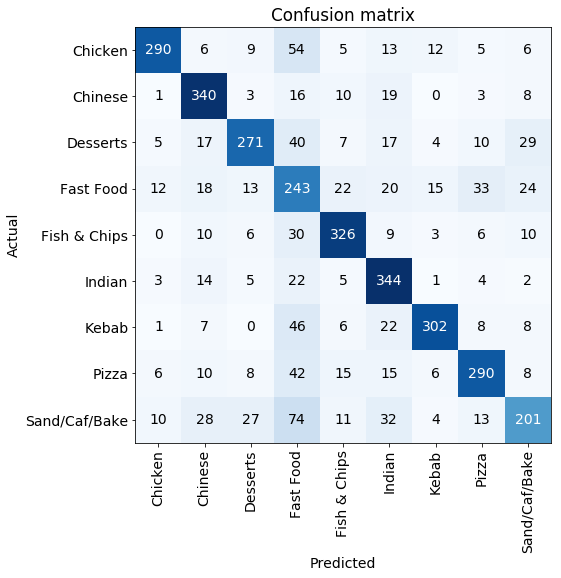

In [165]:
plt.rcParams.update({'font.size': 14})
interp2.plot_confusion_matrix(figsize=(8,8))

In [166]:
#Precision = tp / tp + fp
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [167]:
recall

array([0.725 , 0.85  , 0.6775, 0.6075, 0.815 , 0.86  , 0.755 , 0.725 , 0.5025])

In [168]:
precision

array([0.884146, 0.755556, 0.792398, 0.428571, 0.800983, 0.700611, 0.870317, 0.77957 , 0.679054])

In [169]:
precision.mean()

0.7434673038626968

In [170]:
recall.mean()

0.7241666666666666

In [30]:
np.sum(np.diag(cm)/np.sum(cm, axis = 0)*np.sum(cm, axis = 1))/np.sum(cm)

0.7537410483900304

In [27]:
np.sum(np.diag(cm))/np.sum(np.sum(cm, axis = 1))

0.7372222222222222